In [1]:
import sys
sys.path.append('/usr/local/lib/python2.7/dist-packages')
sys.path.append('/usr/local/lib/python3.5/dist-packages')
sys.path

['/home/ga96kub/3d_retrieval',
 '/opt/anaconda3/lib/python37.zip',
 '/opt/anaconda3/lib/python3.7',
 '/opt/anaconda3/lib/python3.7/lib-dynload',
 '',
 '/opt/anaconda3/lib/python3.7/site-packages',
 '/opt/anaconda3/lib/python3.7/site-packages/IPython/extensions',
 '/home/ga96kub/.ipython',
 '/usr/local/lib/python2.7/dist-packages',
 '/usr/local/lib/python3.5/dist-packages']

In [2]:
import create_dict
import torch
import os
import json
import utils
import numpy as np

# Clean Data

In [ ]:
#folder_name = '/data2'
#create_dict.clean_obj(folder_name)

# Generate Dataset

In [ ]:
#!pip3 freeze | grep PyWavefront

In [ ]:
#import pywavefront
#mesh2 = pywavefront.Wavefront('/home/.schramm/Documents/3d_retrieval/data/02747177/8bdea15ae5d929d0a2eb129d649f68cf/models/model_normalized.obj', collect_faces='True')


In [ ]:
input_folder = '/data'
suffix = '_allClasses1000_points2500' #suffix will append data_trainxxxx.json
max_elements_per_class = 1000
create_dict.create_dictionary(input_folder, max_elements_per_class, suffix, points_per_object=2500)

# Initialize Network

In [3]:
import SiameseNet

device = torch.device("cuda:0" if torch.cuda.torch.cuda.is_available() else "cpu")

batch_size = 16
net = SiameseNet.SiameseNet(batch_size)
suffix = '_allClasses1000_points2500' # comment in if not coming from generating the dataset
path_to_params = "models/_allCl1000_P2500_BS16_classLoss.pt" # if file does not exist or is empty it starts from untrained and later saves to the file

# shift to GPU if available

net.to(device)
working_dir = os.getcwd()
data_dir_train = os.path.join(working_dir, 'data_train'+suffix+'.json')
data_dir_val = os.path.join(working_dir, 'data_val'+suffix+'.json')
class_dir = os.path.join(working_dir, 'class_dict'+suffix+'.json')

path_to_hidden = str(path_to_params[:-3] + '_hidden.pt')
if os.path.isfile(path_to_hidden):
    net.hidden = torch.load(path_to_hidden)
if os.path.isfile(path_to_params):
    if os.stat(path_to_params).st_size != 0:
        net.load_state_dict(torch.load(path_to_params, map_location=device))  #Loads pretrained net if file exists and if not empty
else:
    open(path_to_params, "x") #Creates parameter file if it does not exist

In [ ]:
device

# Train Network

In [ ]:
#training parameters

writer_suffix = 'allC1000_LRe-3_MR05_classLoss'
margin = 0.5
num_epochs = 100
print_batch = 30
lr = 0.001



In [ ]:
net = SiameseNet.train(net, num_epochs, margin, lr, print_batch, 
                       data_dir_train, data_dir_val, writer_suffix, path_to_params, working_dir, class_dir)

# Validation

In [ ]:
margin = 0.5
writer_suffix = 'allC1000_LRe-3_MR05'
SiameseNet.val(net, margin, data_dir_val, writer_suffix, working_dir, class_dir, k=1,  images=False)

# Retrieval

In [4]:
y_true, y_pred, ids, shape, description = SiameseNet.retrieval(net, data_dir_val, working_dir, print_nn=False)

Loaded 5032 word vectors.
Number of validation triplets: 934


0 ID: 181d03027d30429dced68ac20944148  Descr.: this is a silver color metal speaker unit and square
1 ID: 82346c794fd098f77a1f550045b16384  Descr.: a steel grey framed semi circle table with white top and three legs
2 ID: f4a0d0169abf306a754ec1f2eef2c6cc  Descr.: this is an l shaped couch that is dark blue with lighter blue seat cushions and white curved cushions on top


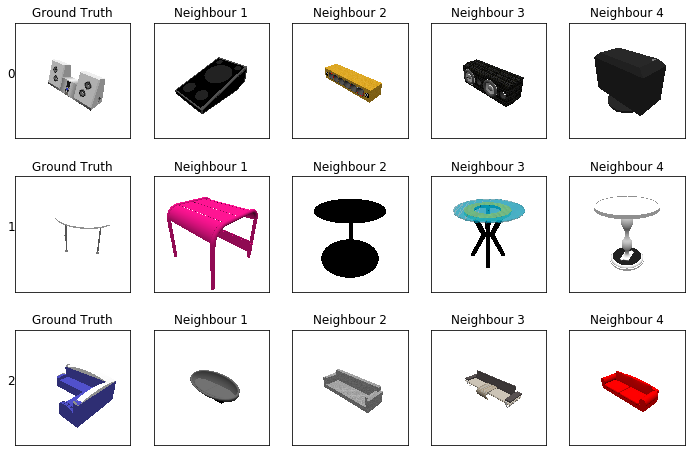

In [5]:
utils.retrieve_images(y_pred, ids, data_dir_val, class_dir, num_KNN=4, max_show=3, shuffle=True)

Enter sentencethis is a wooden chair
Description: this is a wooden chair


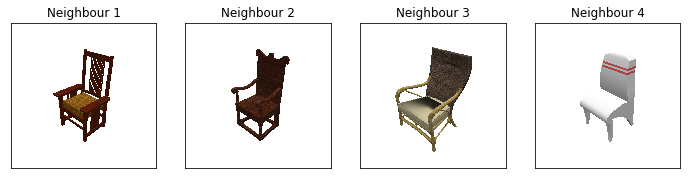

In [9]:
#sentence = 'This is a black chair'
sentence = input("Enter sentence")
utils.retrieve_one_sentence(net, data_dir_val, working_dir, sentence, class_dir, y_pred , ids, shape, num_KNN=4)